## 4）朴素贝叶斯分类器

我们注意，**拟然率**（或，**类条件概率**）$P(\boldsymbol{x} \ | \ y)$的样本$\boldsymbol{x}$是多个属性组成的向量，也就是说$P(\boldsymbol{x} \ | \ y)$是所有属性的联合概率，很难从有限的训练样本中直接估计而来。 

为了避免这个障碍，**朴素贝叶斯分类器**采用了“**属性条件独立性假设**”，于是前面**贝叶斯最优分类器**可以简化成**朴素贝叶斯分类器**：

$$
h^*(\boldsymbol{x}) = \underset{c \in \mathbf{Y}}{\mathrm{argmax}} \ P(c) \prod_{j=1}^n P(x_j\ |\ c)
$$

### 训练过程之先验概率$P(c)$估计

如果有充足的独立同分布样本，可以通过频率统计构成**先验概率分布**：

$$
P(c) = \dfrac{\left| D_c \right|}{m}
$$

其中，$D_c$代表标记为$c$类的样本集。

### 训练过程之拟然率$P(x_j\ |\ c)$估计

- 如果是离散属性，无需估计拟然参数，也可以通过频率统计构成**类条件概率**(即，**拟然率**)的分布：

$$
P(x_j\ |\ c) = \dfrac{\left|D_{c,x_j} \right|}{\left|D_c \right|}
$$

其中，$D_{c,x_j}$代表在$D_c$样本集中，第$j$个属性取值为$x_j$的样本集合。

- 如果是连续属性，我们需要首先假设概率分布形式。假设我们选择正态分布，其概率密度函数为$p(\boldsymbol{x}\ | \ c)\sim \mathbf{N}(\boldsymbol{\mu}_c, \boldsymbol{\sigma}_c^2)$，那么对应的**对数拟然函数**$LL(\boldsymbol{\mu}_c, \boldsymbol{\sigma}_c)$可写成：

$$
LL(\boldsymbol{\mu}_c, \boldsymbol{\sigma}_c) = \sum_{\boldsymbol{x} \in D_c} \sum_{j=1}^n \ln p(x_j \ | \ c :  \mu_{c,j}, \sigma_{c,j})
$$

容易求出其最大拟然估计$\hat{\boldsymbol{\mu}}_c, \hat{\boldsymbol{\sigma}}_c$:

$$
\hat{\boldsymbol{\mu}}_c = \dfrac{1}{|D_c|} \sum_{\boldsymbol{x} \in D_c} \boldsymbol{x}
$$

$$
\hat{\boldsymbol{\sigma}}_c^2 = \dfrac{1}{|D_c|} \sum_{\boldsymbol{x} \in D_c} (\boldsymbol{x} - \hat{\boldsymbol{\mu}}_c)^T (\boldsymbol{x} - \hat{\boldsymbol{\mu}}_c)
$$

这个结果，恰好和$\boldsymbol{\mu}_c, \boldsymbol{\sigma}_c$原本该有的含义一致。 一旦有了最大拟然估计的参数，**拟然率**的分布也就确定了。

下面将**朴素贝叶斯分类器的流程**总结如下：

----------------------------------------

【训练阶段】

1）通过频率统计，确定目标的先验概率$P(c)$；

2）对于离散属性(假设有$d$个)，通过频率统计确定该属性的类条件概率（拟然率）分布$P(x_j\ | \ c)$；

3）对于连续属性(有$n - d$个)，先假设服从的概率分布（带参数$\boldsymbol{\theta}$），然后通过最大拟然估计出$\hat{\boldsymbol{\theta}}$，进而可以确定类条件概率密度（拟然率）$p(x_j\ | \ c : \hat{\boldsymbol{\theta}})$；

【预测阶段】

4）根据下式对任意给出的样本$\boldsymbol{x}$预测其所属类别：

$$
h^*(\boldsymbol{x}) = \underset{c \in \mathbf{Y}}{\mathrm{argmax}} \ P(c) \prod_{j=1}^d P(x_j\ |\ c) \prod_{j=d+1}^n p(x_j\ |\ c: \hat{\boldsymbol{\theta}})
$$

特别地，如果全是连续属性，并且选择正态分布，那么上式可以改写成：

$$
h^*(\boldsymbol{x}) = \underset{c \in \mathbf{Y}}{\mathrm{argmin}} \ \left[\sum_{j=1}^n \left(\dfrac{(x_j - \hat{\mu}_{c,j})^2}{2 \hat{\sigma}_{c,j}^2} +  \ln(\sqrt{2 \pi} \hat{\sigma}_{c,j}) \right) - \ln P(c) \right]
$$

----------------------------------------

下面的Python代码是朴素贝叶斯分类器的忠实实现（只用来展示原理）：

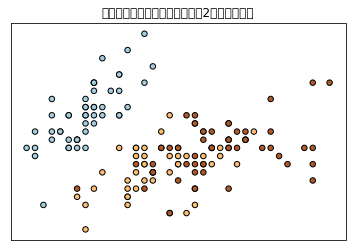

In [4]:
from sklearn import datasets
import matplotlib.pyplot as plt

'''
    原始数据集
'''

# 获取数据集
iris = datasets.load_iris()
X = iris.data; y = iris.target
m,n = X.shape
labs = list(set(y))
N = len(labs)

# 绘制这个数据集一个侧面的散点图
plt.scatter(X[:, 0], X[:, 1], s=30, c=y, cmap=plt.cm.Paired,edgecolors='k')
plt.xticks(())
plt.yticks(())
plt.title(u"数据集给出的标定（只绘制了头2个属性空间）")
plt.show()

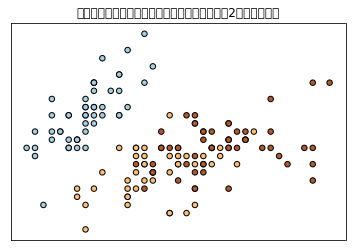

In [5]:
'''
    手工代码实现朴素贝叶斯分类
'''

# 计算先验概率
Prior = 1.0*np.bincount(y)/m  

# 假设各属性都服从正态分布，于是其参数最大拟然估计，就是均值和标准差。
# 计算均值矩阵和标准差矩阵： 表示第i类第j个属性的均值和标准差
Mu = np.zeros((N,n))
Sigma = np.zeros((N,n))
for i in range(N):
    Mu[i] = X[y==labs[i]].mean(axis=0)
    Sigma[i] = X[y==labs[i]].std(axis=0)

# 训练期间，拟然率无需计算， 预测的时候临时计算

# 根据上面最后一个公式计算每个样本的预测值
L = np.zeros((m,N))
for i in range(N):
    L[:,i] = ((X - Mu[i])**2 / (2*Sigma[i]**2)).sum(axis=1) + np.log(Sigma[i]*np.sqrt(2*np.pi)).sum() - np.log(Prior[i])
y_pred = L.argmin(axis=1)

# 绘制这个数据集一个侧面的散点图
plt.scatter(X[:, 0], X[:, 1], s=30, c=y_pred, cmap=plt.cm.Paired,edgecolors='k')
plt.xticks(())
plt.yticks(())
plt.title(u"手工代码实现贝叶斯分类给出标定（只绘制了头2个属性空间）")
plt.show()

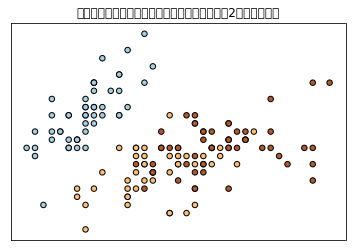

手工代码正确性比对(以机器学习算法包为准):True


In [8]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
y1_pred = gnb.fit(X,y).predict(X)
# 绘制这个数据集一个侧面的散点图
plt.scatter(X[:, 0], X[:, 1], s=30, c=y1_pred, cmap=plt.cm.Paired,edgecolors='k')
plt.xticks(())
plt.yticks(())
plt.title(u"手工代码实现贝叶斯分类给出标定（只绘制了头2个属性空间）")
plt.show()

print(u'手工代码正确性比对(以机器学习算法包为准):%s'%(y1_pred==y_pred).all())